In [1]:
import pyspark
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [2]:
def getStartDateForData(dataset):
    startDate = 0
    for i in range(1,len(dataset.columns)-2):
        # to find first sunday 
        if datetime.strptime(dataset.columns[i], '%Y-%m-%d').date().weekday() == 6:
            startDate= i
            break;
    return startDate

def getEndDateForData(dataset):
    reverseDatasetColumns = dataset.columns[::-1]
    endDate = len(dataset.columns)

    for i in range(1,len(dataset.columns)-2):
        # to find last saturday 
        if datetime.strptime(reverseDatasetColumns[i], '%Y-%m-%d').date().weekday() == 5:
            endDate -= i
            break;
    return endDate

In [3]:
def dropColumnsFromBegining(dataset):
    dropCol = []
    for col in dataset.columns[1:]:
        date = datetime.strptime(col,'%Y-%m-%d')
        if date.weekday()!=6:
            dropCol.append(col)
        else:
            break
    return dropCol

def dropColumnsFromEnd(dataset):
    dropCol = []
    reverseData = dataset.columns[-1:]
    for col in reverseData:
        date = datetime.strptime(col,'%Y-%m-%d')
        if date.weekday()!=5:
            dropCol.append(col)
        else:
            break
    return dropCol

In [4]:
spark = SparkSession.builder.appName("Practise").getOrCreate()

22/04/27 13:33:32 WARN Utils: Your hostname, LAPTOP-QB1UBO4T resolves to a loopback address: 127.0.1.1; using 172.17.221.106 instead (on interface eth0)
22/04/27 13:33:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/27 13:33:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

In [6]:
fileLocation = 'covid_confirmed_usafacts.csv'

In [7]:
df_pyspark = spark.read.csv(fileLocation, header=True, inferSchema=True)

In [8]:
df_pyspark = df_pyspark.filter(df_pyspark['State']=='CA')

In [9]:
df_pyspark = df_pyspark.drop('County Name','StateFIPS','State')

In [10]:
startDateNewCases = getStartDateForData(df_pyspark)
endDateNewCases = getEndDateForData(df_pyspark)

In [11]:
# total_cols = len(df_pyspark.columns)-2

In [12]:
# for i in range(2,total_cols):
#     df_pyspark = df_pyspark.withColumn(df_pyspark.columns[i],(df_pyspark[df_pyspark.columns[i]]-df_pyspark[df_pyspark.columns[i-1]]))

In [13]:
dropColsStart = dropColumnsFromBegining(df_pyspark)
df_pyspark = df_pyspark.drop(*dropColsStart)

In [14]:
dropColsEnd = dropColumnsFromEnd(df_pyspark)
df_pyspark = df_pyspark.drop(*dropColsEnd)

In [15]:
weeklyData = df_pyspark.select(df_pyspark.columns[1::7])

In [16]:
total_cols = len(weeklyData.columns)

In [17]:
for i in range(2,total_cols):
    weeklyData = weeklyData.withColumn(weeklyData.columns[i],(weeklyData[weeklyData.columns[i]]-weeklyData[weeklyData.columns[i-1]]))

In [18]:
import pyspark.pandas as ps
weeklyDataNew = ps.DataFrame(weeklyData)

In [19]:
county = ps.DataFrame(df_pyspark.select('countyFIPS'))
weeklyDataNew = county.merge(weeklyDataNew, left_index=True, right_index=True)

In [20]:
weeklyDataNew = weeklyDataNew.iloc[1:,:]

In [21]:
weekly = weeklyDataNew.to_spark()

# AWS CLI Export

aws emr create-cluster --os-release-label 2.0.20220406.1 --applications Name=Hadoop Name=Spark --ec2-attributes '{"KeyName":"emr-key-day-2","InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-4f4dd629","EmrManagedSlaveSecurityGroup":"sg-03ea5cbd966c641f1","EmrManagedMasterSecurityGroup":"sg-0b5652a0c362e1ca8"}' --release-label emr-6.6.0 --log-uri 's3n://big-data-assgn-3/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://big-data-assgn-3/awsCodeSparkSQL.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"},{"Args":["spark-submit","--deploy-mode","client","s3://big-data-assgn-3/awsCode.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"},{"Args":["spark-submit","s3://big-data-assgn-3/awsCode.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"},{"Args":["spark-submit","s3://big-data-assgn-3/awsCodeSparkSQL.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"},{"Args":["spark-submit","s3://big-data-assgn-3/awsCodeSparkSQL.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"},{"Args":["spark-submit","s3://big-data-assgn-3/awsCode.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"},{"Args":["spark-submit","s3://big-data-assgn-3/awsCodeSparkSQL.py","--data_source","s3://big-data-assgn-3/covid_confirmed_usafacts.csv","--output_uri","s3://big-data-assgn-3"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Covid Analysis"}]' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"MASTER","InstanceType":"m5.xlarge","Name":"Master - 1"},{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"CORE","InstanceType":"m5.xlarge","Name":"Core - 2"}]' --auto-scaling-role EMR_AutoScaling_DefaultRole --bootstrap-actions '[{"Path":"s3://big-data-assgn-3/emr_bootstrap.sh","Name":"Custom action"}]' --ebs-root-volume-size 10 --service-role EMR_DefaultRole --enable-debugging --auto-termination-policy '{"IdleTimeout":3600}' --name 'spark-sql' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-west-1

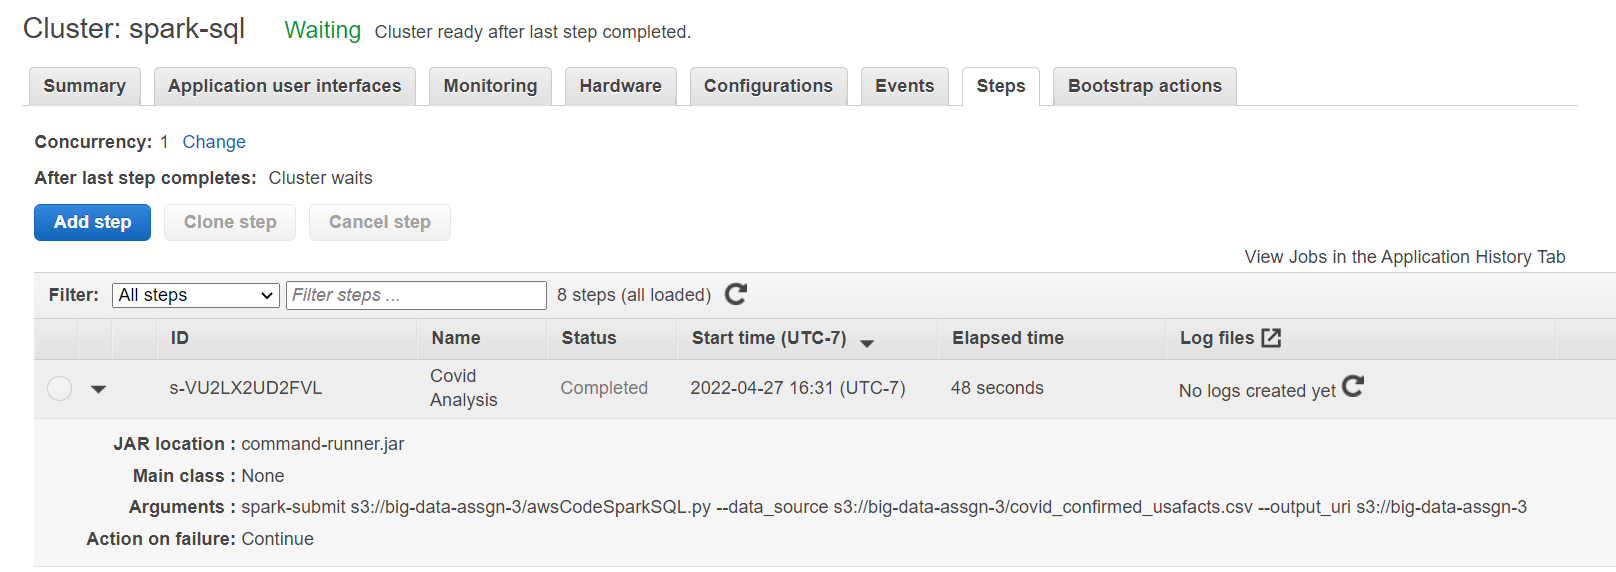

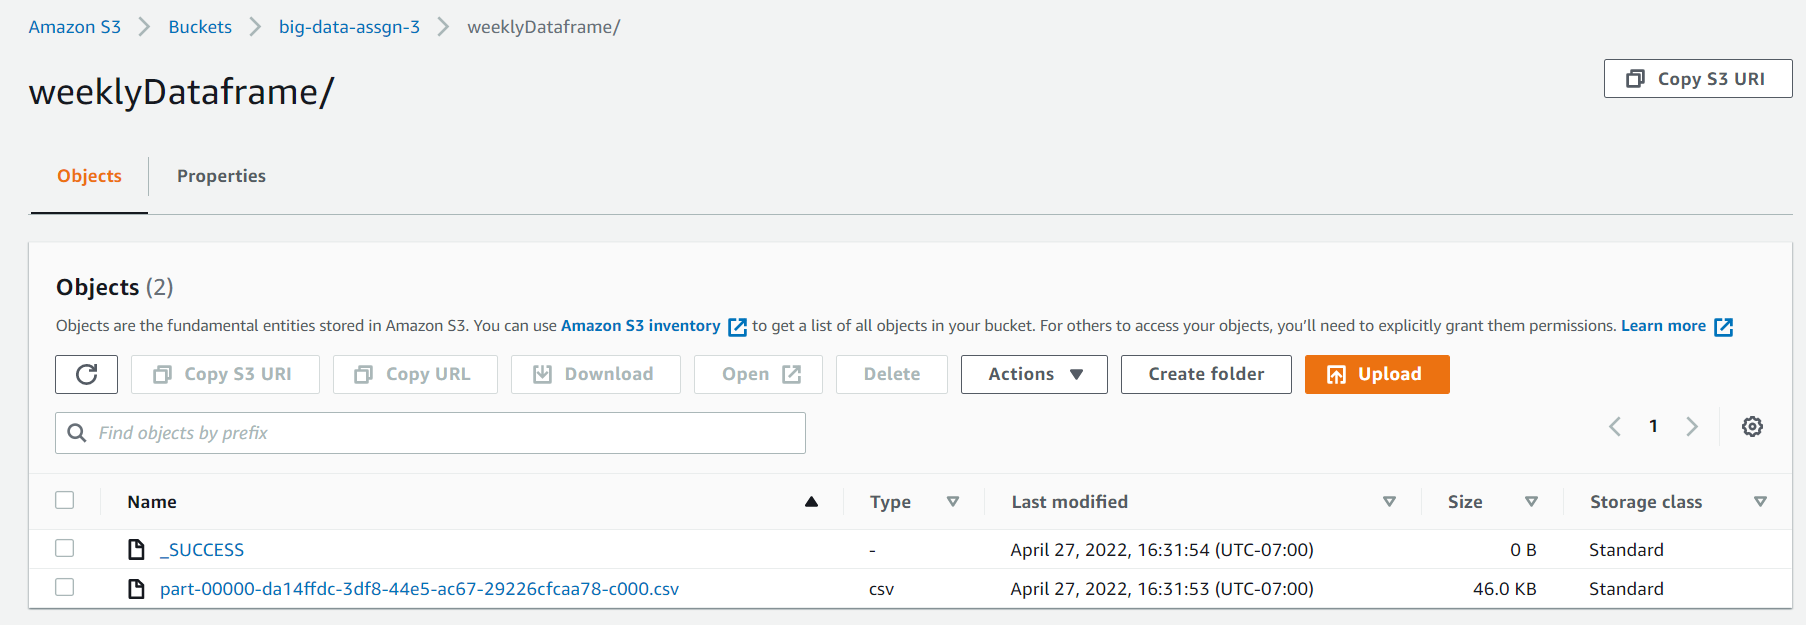